# Search Algorithm
---

Consider an autonomous mobile robot in a crowded environment that needs to find  an  efficient  pathfrom  its  current  location S to  a  desired  location G.  As  an idealization of the situation, assume that theobstacles (whatever they may be) are  abstracted  by  polygons.  The  problem  now  reduces  to  finding  theshortest path between two points in a plane that has convex polygonal obstacles.

    (a) How do we formulate the state-space? How many states are there? How many paths are there tothe goal? Think carefully to define a good state-space. Justify your decisions.
    
        Formution of state space id to discretize the continuos space and model it as a graph.
    
    (b) How do we define the actions in your formulation of the state-space?
    
        Action is moving from one point to another.
        
    (c)  Formulate  this  problem  in  Python  by  subclassing  the  Problem  class  in “search.py” of the  reference implementation.  Take  extra  care  to  implement ACTIONS to find successor states of a given state.
        
        refer problem.py
     
    (d)  Define  your  evaluation  function  to  evaluate  the  goodness  or  badness  of  a state using an admissible heuristics function 
        
        Uses Euclidean distance as an heuristic.
        
    (e) Create several instances (at least 100) of this problem by randomly generating planes with randomstart and goal points and random polygons as obstacles.
    
        refer Test generation in this file
    
    (f) Solve all the instancesusing the following search strategies:
        _ Any basic strategy of your choice (DFS/BFS/IDS)
        _ Best-first greedy search
        _ A* search
        
        You may use the reference Python code to implement these search algorithms.
        
        refer problem.py
    
    (g)  Perform  an  empirical  analysis  in  terms  of  number  of  nodes  generated, expanded,  actual  time  taken,completeness,  optimality,  etc.  Which  algorithm performs better, in general, on all the instances?
      
         refer last section of this file


In [3]:
#done by - Venkataraman-192
#got some help from  siddharth-150 #

from search import Problem
from collections import deque
import heapq
import math
from shapely.geometry import LineString,Polygon

class PathSearch(Problem):
    initial = None
    goal = None
    polygons = None
    pointList = None
    verticesCount = None
    adj_mat = None
    
    def __init__(self, initial, goal, polygons):
        '''
        This class is a subclass of Problem class in search.py
        Initialize the space with initial, goal and polygons.
        Then unzip the polygons into set of vertices and save it as 
        set of nodes with inital and final states in pointList. 
        Edges are formed between these nodes by building an adjacency matrix 
        '''
        
        self.initial = initial
        self.goal = goal
        self.polygons = polygons
        self.pointList = []
        
        self.pointList.append(self.initial)
        for polygon in self.polygons:
            for point in polygon:
                self.pointList.append(point)
        self.pointList.append(self.goal)
        
        self.verticesCount = len(self.pointList)
        self.adj_mat = self.generate_adj_mat() 
        super().__init__(initial,goal)
    
    def isedge(self, polygon, points):
        '''
        This function checks whether the points form an edge of a polygon,
        When the points form an edge of a polygon we say that they dont
        actually intersect with the polygon rather glides through the 
        surface of the polygon.
        '''
        
        n = len(polygon)
        for i in range(n):
            if(points[0] == polygon[i] and points[1] == polygon[(i+1)%n]) or \
                (points[1] == polygon[i] and points[0] == polygon[(i+1)%n]):
                    return True
        
        return False
    
    def generate_adj_mat(self):
        '''
        This function forms the adjaceny matrix using a naive algorithm from
        the set of points/nodes. the adjacency matrix value is infinity if we 
        cannot establish a direct edge connection between two nodes. else the 
        euclidan distance is taken as the edge weight in adjacency matrix. 
        '''
        
        adj = [[math.inf for j in range(self.verticesCount)] for i in range(self.verticesCount)]
        polygon_list = [Polygon(poly) for poly  in self.polygons]
        
        for pos1 in range(self.verticesCount):
            for pos2 in range(self.verticesCount):
                
                point1 = self.pointList[pos1]
                point2 = self.pointList[pos2]
                
                isIntersecting = False
                line = LineString([point1,point2])
                
                for ind, polygon in enumerate(polygon_list):
                    intersectingPoints = list(polygon.intersection(line).coords)
                    
                    if(len(intersectingPoints) > 1):
                        if(len(intersectingPoints)==2 and self.isedge(self.polygons[ind],intersectingPoints)):
                            continue
                        else:
                            isIntersecting = True
                            break
                
                if isIntersecting == False:
                    adj[pos1][pos2] = self.EuclideanDistance(point1,point2)
        return adj      
    
    
    def EuclideanDistance(self,point1, point2):
        '''
        Takes in two points and return the Euclidean distance between the two
        given points
        '''
        
        return round(((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2  )**0.5,2)
    
    def next_states(self, src):
        '''
        This functions returns a set of nodes that can be directly with the help of
        adjacency matrix generated, The function returns all those nodes(dest) other than 
        src that has an finite value in adjacency matrix.
        '''
        
        return [dest for dest in range(self.verticesCount) if(self.adj_mat[src][dest] != math.inf and src != dest)]
                    
    def goal_test(self,state):
        '''
        This function checks whether the provided state is goal state or not
        '''
        
        return self.pointList[state] == self.goal
        
    def edge_cost(self, state1, state2):
        '''
        This function return the weight of the edge between two nodes provided
        '''
        
        return self.adj_mat[state1][state2]
    
    def value(self, state):
        '''
        This function can be used as an Heuristic for Informed searches or 
        Local search algorithms. It return the Euclidean distance between 
        the given node and the goal node.
        '''
        
        point  = self.pointList[state]
        return self.EuclideanDistance(point, self.goal)
    
    def set_path(self, goal, parent):
        '''
        Generates the path list to reach from source to destination
        '''
        
        start = goal
        path = []
        while start:
            path.append(start)
            start = parent[start]
        path.append(0)
        path = path[::-1]
        return path
    
    def total_cost(self, path):
        '''
        Takes in the path and return the total cost of the path
        '''
        
        return sum([self.edge_cost(path[i],path[i+1]) for i in range(len(path)-1)])
    
    def bfs(self, verbose=False):
        parent = dict()
        discovered = deque()
        explored = set()
        
        discovered.append(0)
        explored.add(0)
        
        while discovered:
            if verbose:
                print('Queue : ', discovered)
            state = discovered.popleft()
            for next_state in self.next_states(state):
                if self.goal_test(next_state):
                    parent[next_state] = state
                    path = self.set_path(next_state, parent)
                    return path, self.total_cost(path)
                elif next_state not in explored:
                    explored.add(next_state)
                    discovered.append(next_state)
                    parent[next_state] = state
        
        return None, math.inf
    
    def gbfs(self, verbose=False):
        parent = dict()
        discovered = []
        explored = set()
        
        discovered.append((self.value(0), 0))
        
        while discovered:
            if verbose:
                print('Discovered ', len(discovered), ' nodes')
            val, state = heapq.heappop(discovered)

            if state in explored:
                continue
            
            explored.add(state)
            
            if self.goal_test(state):
                path = self.set_path(state, parent)
                return path, self.total_cost(path)
            
            for next_state in self.next_states(state):
                if next_state not in explored:
                    parent[next_state] = state
                    heapq.heappush(discovered, (self.value(next_state), next_state))
        
        return None, math.inf
    
    def a_star(self, verbose=False):
        parent = dict()
        discovered = []
        explored = set()
        back_cost = dict()
        
        back_cost[0] = 0
        discovered.append((self.value(0), 0))
        
        while discovered:
            if verbose:
                print('Discovered ', len(discovered), ' nodes')
            val, state = heapq.heappop(discovered)

            if state in explored:
                continue
            
            explored.add(state)
            
            if self.goal_test(state):
                path = self.set_path(state, parent)
                return path, self.total_cost(path)
            
            for next_state in self.next_states(state):
                if next_state not in explored:
                    reduced  = False
                    tentative_cost = back_cost[state] + self.edge_cost(state,next_state) + self.value(next_state)

                    if next_state not in back_cost or back_cost[state] + self.edge_cost(state,next_state) < back_cost[next_state]:
                        reduced = True
                        back_cost[next_state] = back_cost[state] + self.edge_cost(state,next_state)
                        
                        if next_state not in [i[1] for i in discovered]:
                            parent[next_state] = state
                            heapq.heappush(discovered, (tentative_cost, next_state))
                        elif reduced:
                            ind = ([i[1] for i in discovered]).index(next_state)
                            discovered[ind] = (tentative_cost, next_state)
                            heapq.heapify(discovered)
        
        return None, math.inf

OSError: [WinError 126] The specified module could not be found

In [1]:
import time
import random
import math
import matplotlib.pyplot as plt
import shapely.geometry as sg
import shapely.ops as so

plt.rcParams["figure.figsize"] = (15,8)

from problem import PathSearch 

OSError: [WinError 126] The specified module could not be found

In [3]:
from collections import deque

#from utils import *


class Problem:
    """The abstract class for a formal problem. You should subclass
    this and implement the methods actions and result, and possibly
    __init__, goal_test, and path_cost. Then you will create instances
    of your subclass and solve them with the various search functions."""

    def __init__(self, initial, goal=None):
        """The constructor specifies the initial state, and possibly a goal
        state, if there is a unique goal. Your subclass's constructor can add
        other arguments."""
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        """Return the actions that can be executed in the given
        state. The result would typically be a list, but if there are
        many actions, consider yielding them one at a time in an
        iterator, rather than building them all at once."""
        raise NotImplementedError

    def result(self, state, action):
        """Return the state that results from executing the given
        action in the given state. The action must be one of
        self.actions(state)."""
        raise NotImplementedError

    def goal_test(self, state):
        """Return True if the state is a goal. The default method compares the
        state to self.goal or checks for state in self.goal if it is a
        list, as specified in the constructor. Override this method if
        checking against a single self.goal is not enough."""
        if isinstance(self.goal, list):
            #return is_in(state, self.goal)
            return state in self.goal
        else:
            return state == self.goal

    def path_cost(self, c, state1, action, state2):
        """Return the cost of a solution path that arrives at state2 from
        state1 via action, assuming cost c to get up to state1. If the problem
        is such that the path doesn't matter, this function will only look at
        state2. If the path does matter, it will consider c and maybe state1
        and action. The default method costs 1 for every step in the path."""
        return c + 1

    def value(self, state):
        """For optimization problems, each state has a value. Hill Climbing
        and related algorithms try to maximize this value."""
        raise NotImplementedError


In [62]:
# This is the set of polygon obstacles, with inital and goal states
polygons = [
    [(2.0,0.5), (12.0, 0.5), (12.0, 4.0), (2.0, 4.0)],
    [(13.5, 2.0), (15.7, 4.5), (13.0, 7.2)],
    [(19.0, 0.7), (21, 1.8), (21.0, 4.0), (19.0,5.8), (17.0, 4.0), (17.0, 1.8)],
    [(5.0, 6.0), (7.0, 10.6), (5.0, 13.8), (1.0, 10.4), (1.8, 7.0)],
    [(7.0, 5.8), (10.0, 5.8), (8.5, 11.0)],
    [(11.0, 9.2), (14.0, 11.8), (13.0, 13.5), (11.3, 13.0)],
    [(14.8, 6.3), (18.7, 6.3), (18.7, 13.0), (14.8, 13.0)],
    [(21.4, 5.5), (22.4, 12.0), (21.0, 13.0), (20.0, 12.3)]
]

initial = (1.0, 2.0)
goal = (23.0, 13.3)
pol_list = [sg.Polygon(p) for p in polygons]

maze = PathSearch(initial, goal, polygons) 

In [63]:
def plot_polygons(pol_list, maze, edges=False, title="Given Polygons with start and goal state"):
    '''
    The function takes in a set of polygons (shapely Polygon objects) and plots them in a plane.
    The variable edge decides whether to display the edges present in the graph or not
    '''
    new_shape = so.cascaded_union(pol_list)
    fig, axs = plt.subplots()
    axs.set_aspect('equal', 'datalim')

    for geom in new_shape.geoms:    
        xs, ys = geom.exterior.xy    
        axs.fill(xs, ys, alpha=0.5, fc='b', ec='none')

    if edges:
        for p1 in range(len(maze.adj_mat)):
            for p2 in range(p1 + 1, len(maze.adj_mat)):
                if maze.adj_mat[p1][p2] != math.inf:
                    axs.plot([maze.pointList[p1][0], maze.pointList[p2][0]], [maze.pointList[p1][1], maze.pointList[p2][1]])    

    plt.scatter(*initial, label="Start State", c='red', s=65)
    plt.scatter(*goal, label="Goal State", c='green', s=65)
    plt.title(title)
    plt.legend()
    plt.show()
    
def plot_path(pol_list, maze, path, title="Given Polygons with start and goal state"):
    '''
    The function takes in a path to reach goal state and prints the edges along the path with the set of polygons
    '''
    new_shape = so.cascaded_union(pol_list)
    fig, axs = plt.subplots()
    axs.set_aspect('equal', 'datalim')

    for geom in new_shape.geoms:    
        xs, ys = geom.exterior.xy    
        axs.fill(xs, ys, alpha=0.5, fc='b', ec='none')
    
    for ind in range(len(path)):
        if ind != len(path)-1:
            axs.plot([maze.pointList[path[ind]][0], maze.pointList[path[ind+1]][0]], [maze.pointList[path[ind]][1], maze.pointList[path[ind+1]][1]])    
        axs.scatter([maze.pointList[path[ind]][0]], [maze.pointList[path[ind]][1]], s=50, c="blue")
    
    plt.scatter(*initial, label="Start State", c='red', s=65)
    plt.scatter(*goal, label="Goal State", c='green', s=65)
    plt.title(title)
    plt.legend()
    plt.show()    

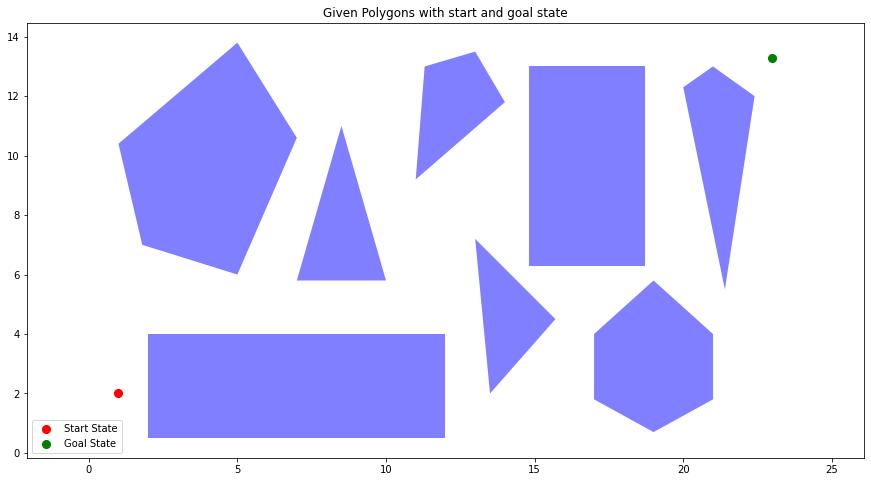

In [64]:
plot_polygons(pol_list, maze)

### Discretizing a continuous state space to perform Uninformed and informed searches

    Idea is to consider the vertices of polygons as nodes and connections (non-intersecting with other polygons) between them as edges.The resulting graph formed can be used to perform various search Algorithms
        

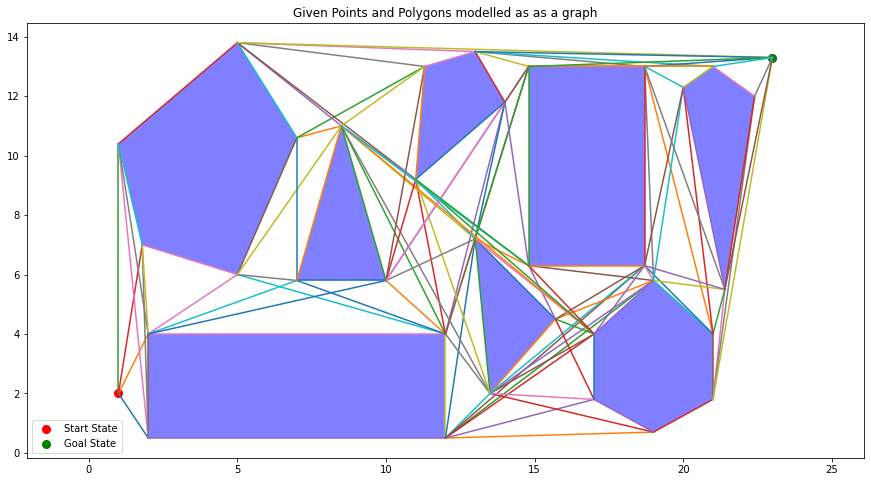

In [65]:
plot_polygons(pol_list, maze, edges=True, title="Given Points and Polygons modelled as as a graph")

# Breath First Search

Path Found :  [0, 17, 16, 34]
Time taken to complete BFS :  0.63 ms


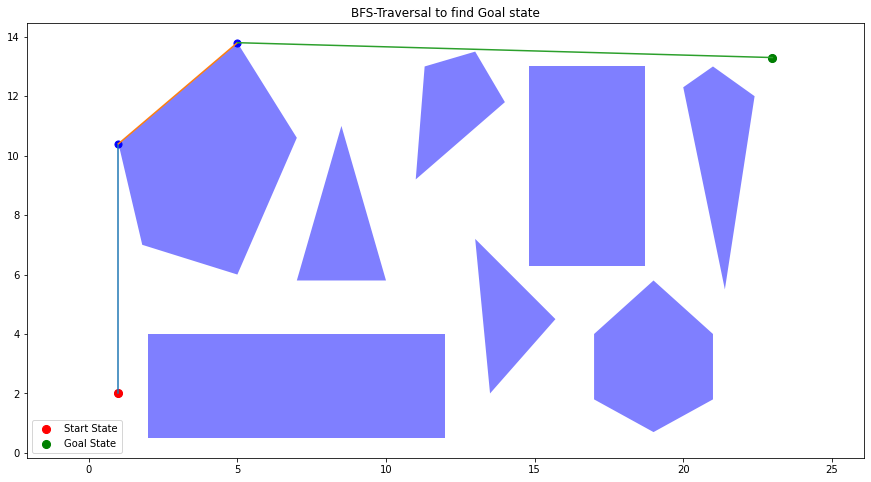

CPU times: user 247 ms, sys: 7.97 ms, total: 255 ms
Wall time: 249 ms


In [43]:
%%time
st = time.time()
bfs_path, bfs_cost = maze.bfs(False)
print("Path Found : ",bfs_path)
et = time.time()
print("Time taken to complete BFS : ", round((et-st)*1000,2), "ms")

plot_path(pol_list, maze, bfs_path, "BFS-Traversal to find Goal state")

# Greedy - Best First Search

Path Found :  [0, 18, 14, 3, 29, 34]
Time taken to complete Greedy-BFS :  0.32 ms


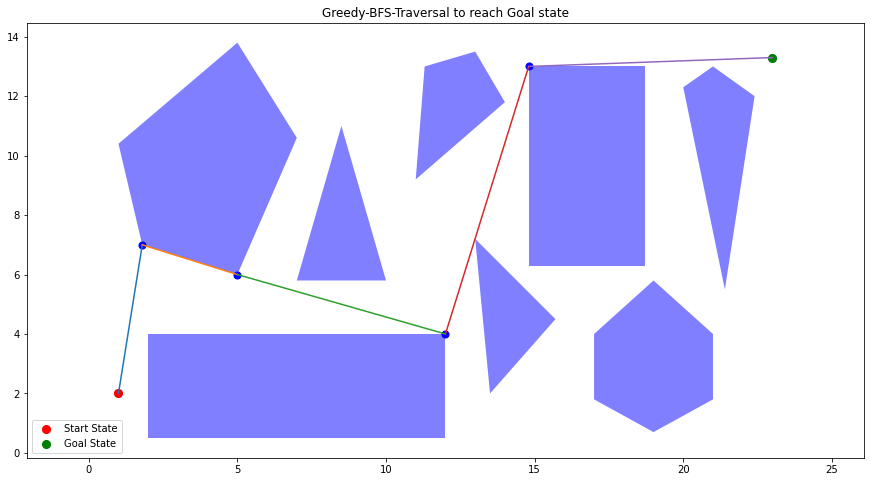

CPU times: user 252 ms, sys: 8.06 ms, total: 260 ms
Wall time: 256 ms


In [44]:
%%time
st = time.time()
gbfs_path, gbfs_cost = maze.gbfs(False)
print("Path Found : ",gbfs_path)
et = time.time()
print("Time taken to complete Greedy-BFS : ", round((et-st)*1000,2), "ms")

plot_path(pol_list, maze, gbfs_path, "Greedy-BFS-Traversal to reach Goal state")

# A* Search

Path Found :  [0, 4, 20, 23, 24, 34]
Time taken to complete A*-Search :  3.8 ms


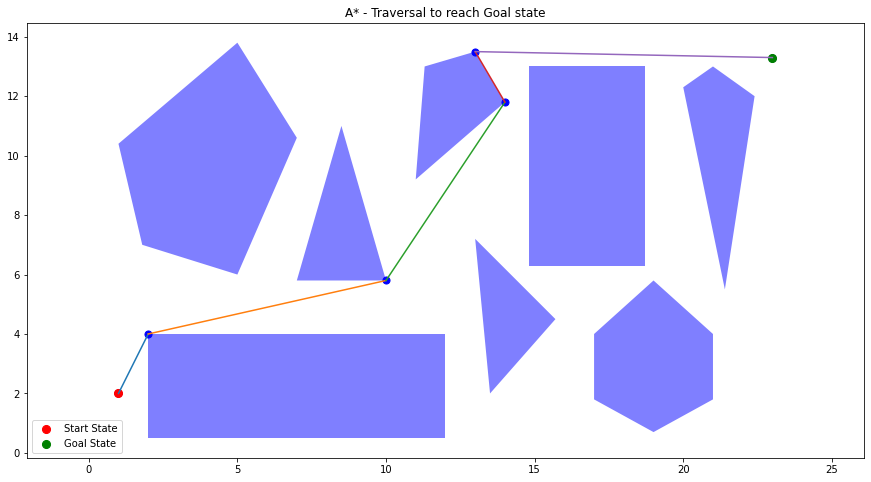

CPU times: user 323 ms, sys: 4.03 ms, total: 327 ms
Wall time: 321 ms


In [45]:
%%time
st = time.time()
a_star_path, a_star_cost = maze.a_star(False)
print("Path Found : ",a_star_path)
et = time.time()
print("Time taken to complete A*-Search : ", round((et-st)*1000,2), "ms")

plot_path(pol_list, maze, a_star_path, "A* - Traversal to reach Goal state")

# Generating random Polygons

The idea is to generate random polygons and test the time taken by each algorithm to reach the goal state
    
 

In [66]:
def gen_poly(count, initial, goal):
    '''
    This function generates 'count' number of non-intersecting polygons 
    '''
    X_MIN = min(initial[0],goal[0])
    X_MAX = max(initial[0],goal[0])
    
    Y_MIN = min(initial[1],goal[1])
    Y_MAX = max(initial[1],goal[1])
    
    polys = []
    
    while count > 0:
        new_poly = []
        num_vertex = 3
        for i in range(num_vertex):
            new_poly.append((random.uniform(X_MIN,X_MAX),random.uniform(Y_MIN,Y_MAX)))
            
        nonInterPoly = True
        for old_poly in polys:
            if sg.Polygon(new_poly).intersects(sg.Polygon(old_poly)):
                nonInterPoly = False
                break
        
        if nonInterPoly:
            polys.append(new_poly)
            count-=1
    
    return polys


In [53]:
initial = (1.0, 2.0)
goal = (23.0 , 13.3)
polygons = gen_poly(4, inital, goal)
pol_list = [sg.Polygon(p) for p in polygons]

maze = PathSearch(inital, goal, polygons)


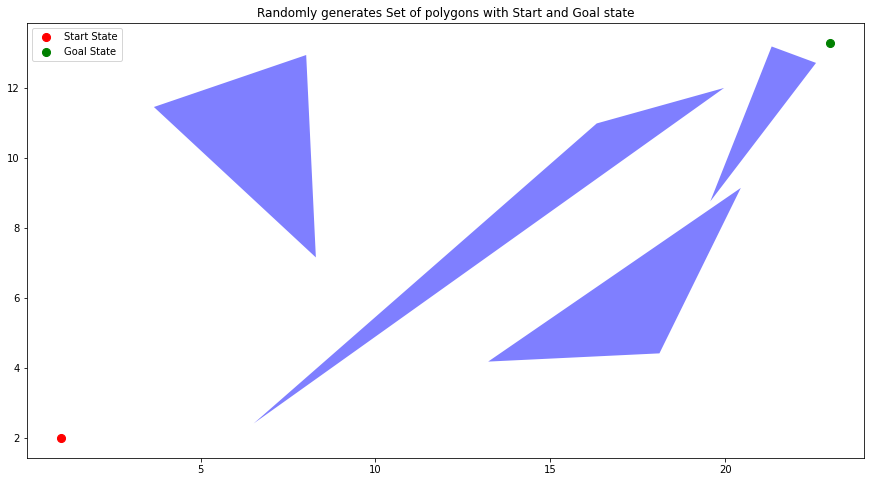

In [54]:
plot_polygons(pol_list, maze, edges = False, title = "Randomly generates Set of polygons with Start and Goal state")

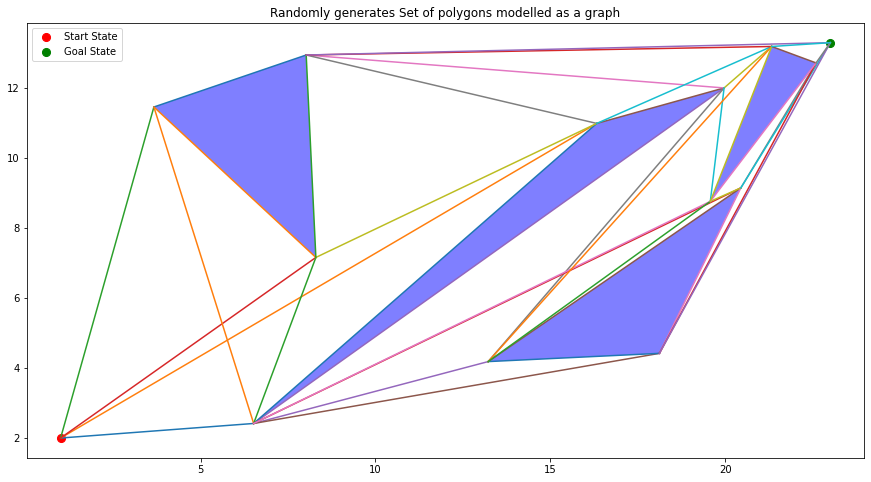

In [55]:
plot_polygons(pol_list, maze, edges = True, title = "Randomly generates Set of polygons modelled as a graph")


### Testing a different sets of polygons with all the three algorithms 

In [47]:
def test_polys(sizes, initial, goal, function):
    '''
    This function takes in sizes and generates different set of polygons,
    to test the time taken by each algorithm to reach the goal state. 
    '''
    times = []
    for size in sizes:
        polygons = gen_poly(size, initial, goal)
        pol_list = [sg.Polygon(p) for p in polygons]
        maze = PathSearch(initial, goal, polygons)
        
        st = time.time()
        func_path, func_cost = function(False)
        et = time.time()
        
        times.append(round((et-st)*1000,2))
    
    return times

In [58]:
sizes = [5,15,20,35,50]
intial = (1.0, 2.0)
goal = (23.0, 13.3)

bfs_times  = test_polys(sizes, initial, goal, maze.bfs)
gbfs_times  = test_polys(sizes, initial, goal, maze.gbfs)
a_star_times  = test_polys(sizes, initial, goal, maze.a_star)

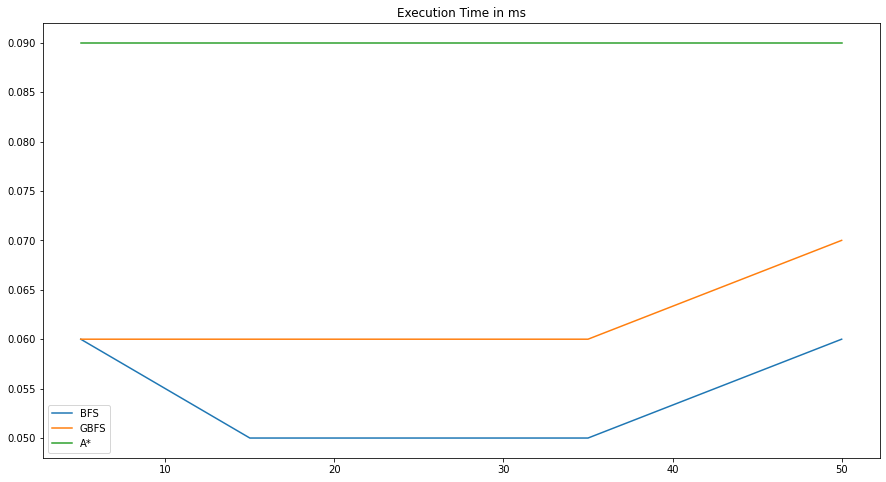

In [59]:
plt.plot(sizes, bfs_times, label="BFS")
plt.plot(sizes, gbfs_times, label="GBFS")
plt.plot(sizes, a_star_times, label="A*")

plt.title("Execution Time in ms")
plt.legend()
plt.show()

### Conclusion:

* BFS though faster , does not find near optimal path
* Greedy-BFS faster than A*, does not contain shortest path
* A* though slower finds an near optimal path